In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean
from scipy import constants as cst
from scipy import signal
from scipy.stats import linregress
from scipy.signal import find_peaks, peak_prominences
from scipy.signal import freqz, lfilter, welch
from scipy import fftpack
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import math
from scipy.constants import find, physical_constants, c
import datetime
import scipy.special
from math import factorial

In [21]:
# Constants
freq = 1e9
c = 3e8 
wavelength = c/freq 
k = 2 * np.pi / wavelength  # Wavenumber
phi0 = 10  #  phase shift (in radians) (about 578*np.pi/180, where 578 in degrees)
r0 = wavelength  
L = 6 # Length of the observation grid 
grid_size = 500000    # number of grid points
dx = L / grid_size  # Spatial resolution

# Coordinate grids
x = np.linspace(-L / 2, L / 2, grid_size)
X = x / wavelength  

# Phase Screen (Gaussian lens)
phi = -phi0 * np.exp(-x**2 / r0**2)

#array of z/lambda and z_values
Z_lambda = [0.1, 0.3, 0.5, 0.8, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 10.0]
z_values = [z * wavelength for z in Z_lambda]


In [22]:
#Multiple phase screens
# n_screens = 10

# for i in range(n_screens):
#     # Step 1: Phase screen
#     phase_screen = generation_of_phase_screen_step1(phi, z_values,k)
#     U *= phase_screen


def generation_of_phase_screen_step1(phi, z_values,k):
    #generating of phase screen
    U = np.ones(grid_size, dtype=complex)  # Initial electric field (plane wave)
    U *= np.exp(1j * phi)  # Apply the phase screen
    return U

In [23]:
def fourier_step2(phi, z_values,k):
    # Step 2: Free-space propagation (Fourier domain multiplication)
    U_fft = np.fft.fftshift(np.fft.fft(generation_of_phase_screen_step1(phi, z_values, k)))

    # Create spatial frequency grid
    K = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(grid_size, d=dx)) # it's like a list of sample rates 
    #f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even (четн) ,  n = grid_size in my case
    #f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd (нечетн)
    
    
    numerical_results = []
    for zi in z_values:
        
        H = np.exp(1j * zi * K**2/(2*k) + 1j*K*x)  
        U_prop_fft = U_fft * H
        U_prop = np.exp(-1j * k * zi)*np.fft.ifft(np.fft.ifftshift(U_prop_fft))
      
        
        # Intensity pattern
        intensity = np.abs(U_prop)**2
        numerical_results.append(intensity)
    
    return numerical_results

In [24]:
def calculate_E_theoretical(x, z_values, k, r0, phi0, max_n=170):
    I_theory = []
    for zi in z_values:
        summation = np.zeros_like(x, dtype=np.complex128)
        E = np.exp(1j * k * zi + 1j * k * x**2 / (2 * zi)) / np.sqrt(1j * k * zi)
        for n in range(max_n):
            term = ((1j * phi0) ** n) /factorial(n)
            term *= (2 * n / ((k * r0)**2) - 1j / (k * zi)) ** -0.5
            term *= np.exp(-x**2/(2*zi**2)/((2 * n / ((k * r0)**2) - 1j / (k * zi))))
            summation += term
        E *= summation
        intensity = np.abs(E)**2
        I_theory.append(intensity)
    return I_theory

In [25]:
# Get Numerical and Theoretical Results
numerical_results = fourier_step2(phi, z_values, k)
I_theory = calculate_E_theoretical(x, z_values, k, r0, phi0)

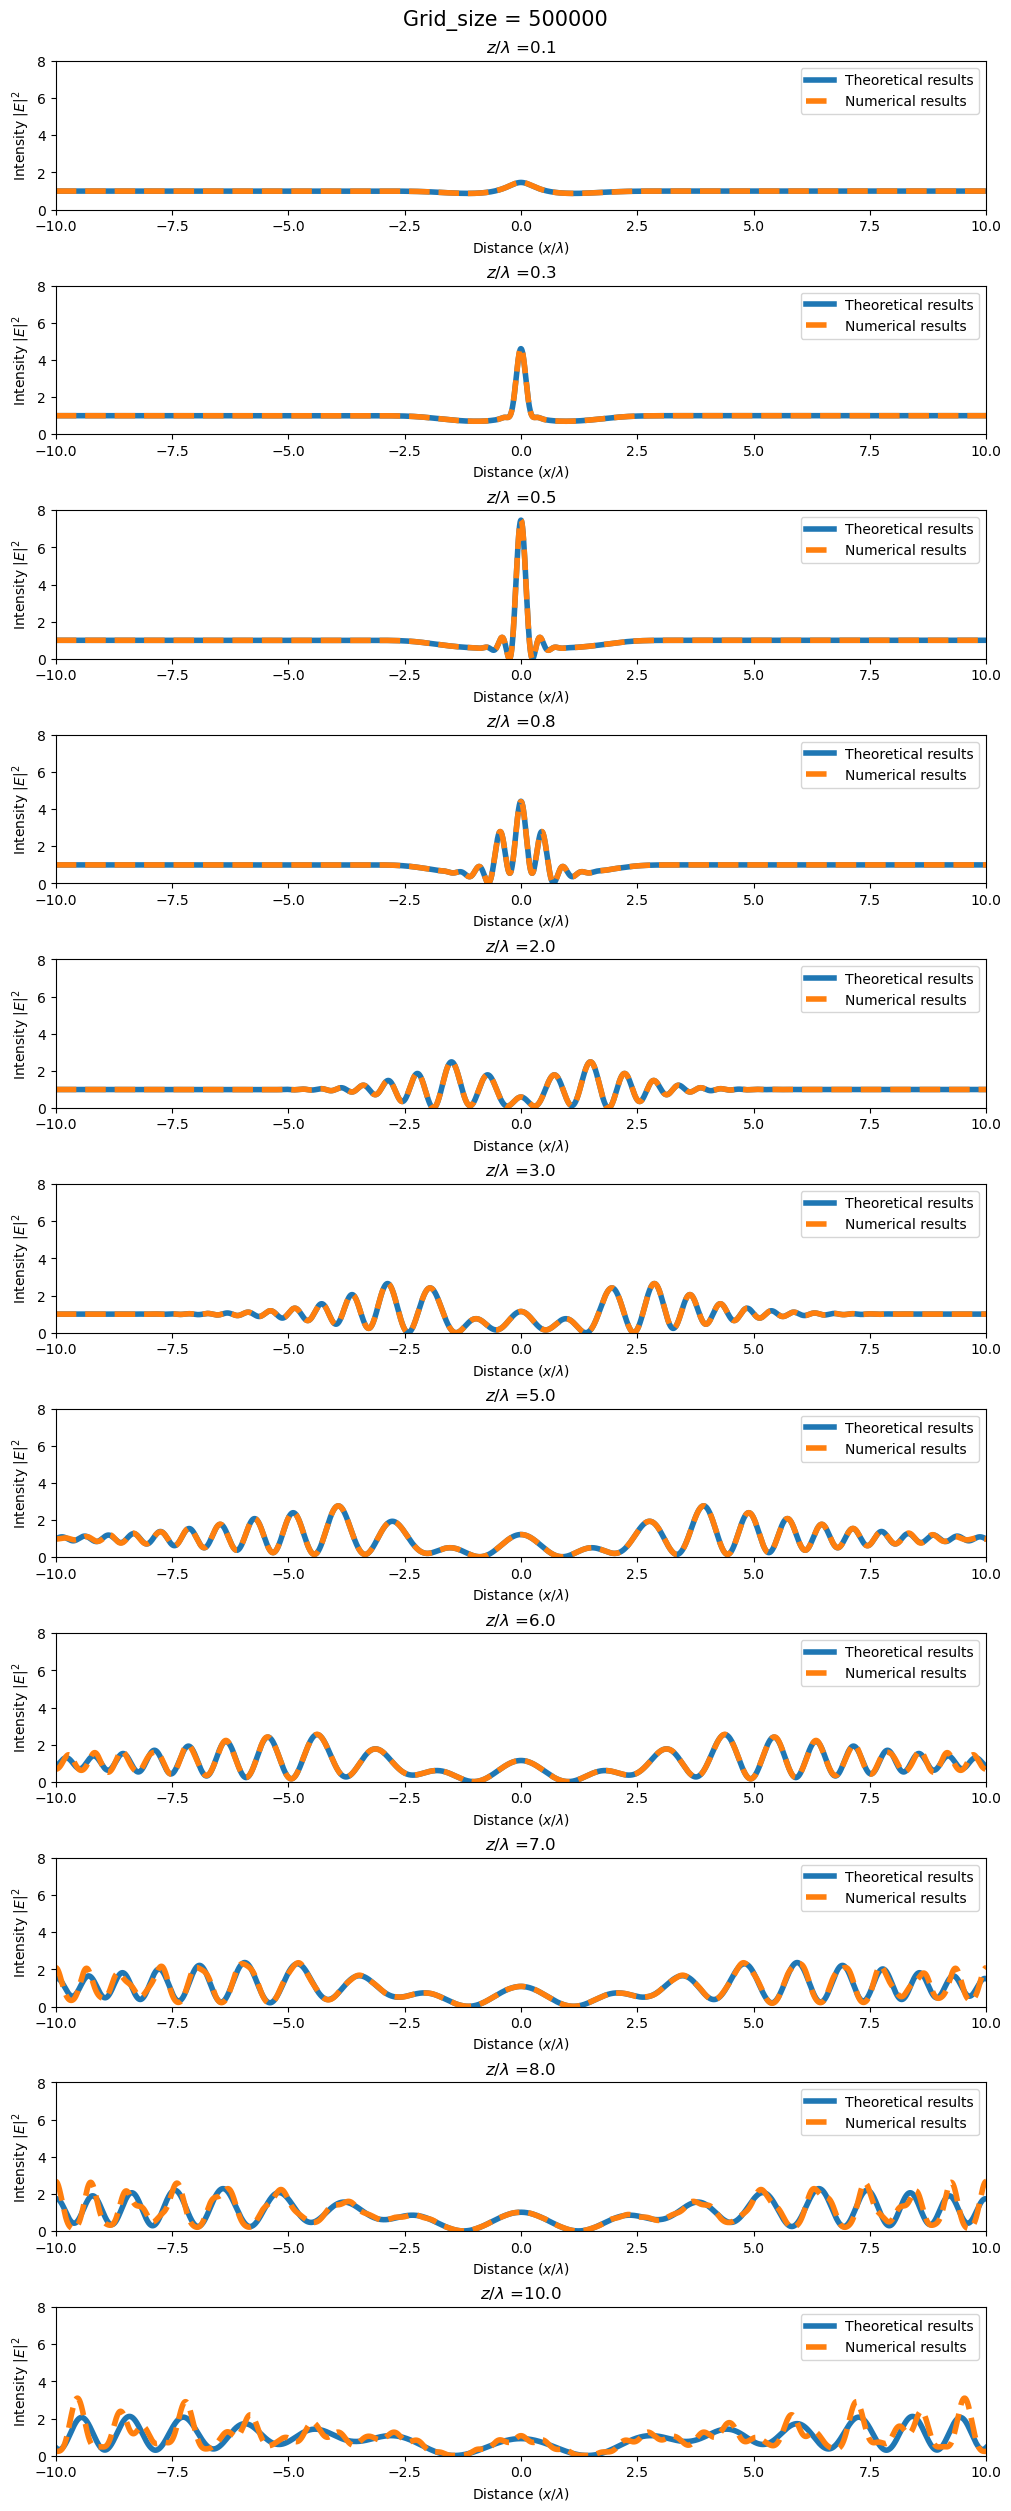

In [26]:
fig, axs = plt.subplots(len(z_values), 1, figsize=(10, 25), constrained_layout=True)

# Add a common title
fig.suptitle(r"Grid_size = " + f"{grid_size}", fontsize=15)

for i, (zi, num_intensity, th_intensity) in enumerate(zip(Z_lambda, numerical_results, I_theory)):
    
    axs[i].plot(X, th_intensity, label="Theoretical results", linewidth = 4)  # Changed to "Theoretical results"
    axs[i].plot(X, num_intensity, label="Numerical results", linewidth = 4, linestyle = "--")  # Changed to "Numerical results"
    axs[i].set_title(r"$z / \lambda$ =" + f"{zi}")
    axs[i].set_xlabel(r"Distance $(x / \lambda)$")
    axs[i].set_ylabel("Intensity $|E|^2$")
    axs[i].set_xlim([-10, 10])
    axs[i].set_ylim([0, 8])
    axs[i].legend()  # Add legend

# Save the figure
plt.savefig(f"{grid_size}_overlay.png", dpi='figure')
plt.show()

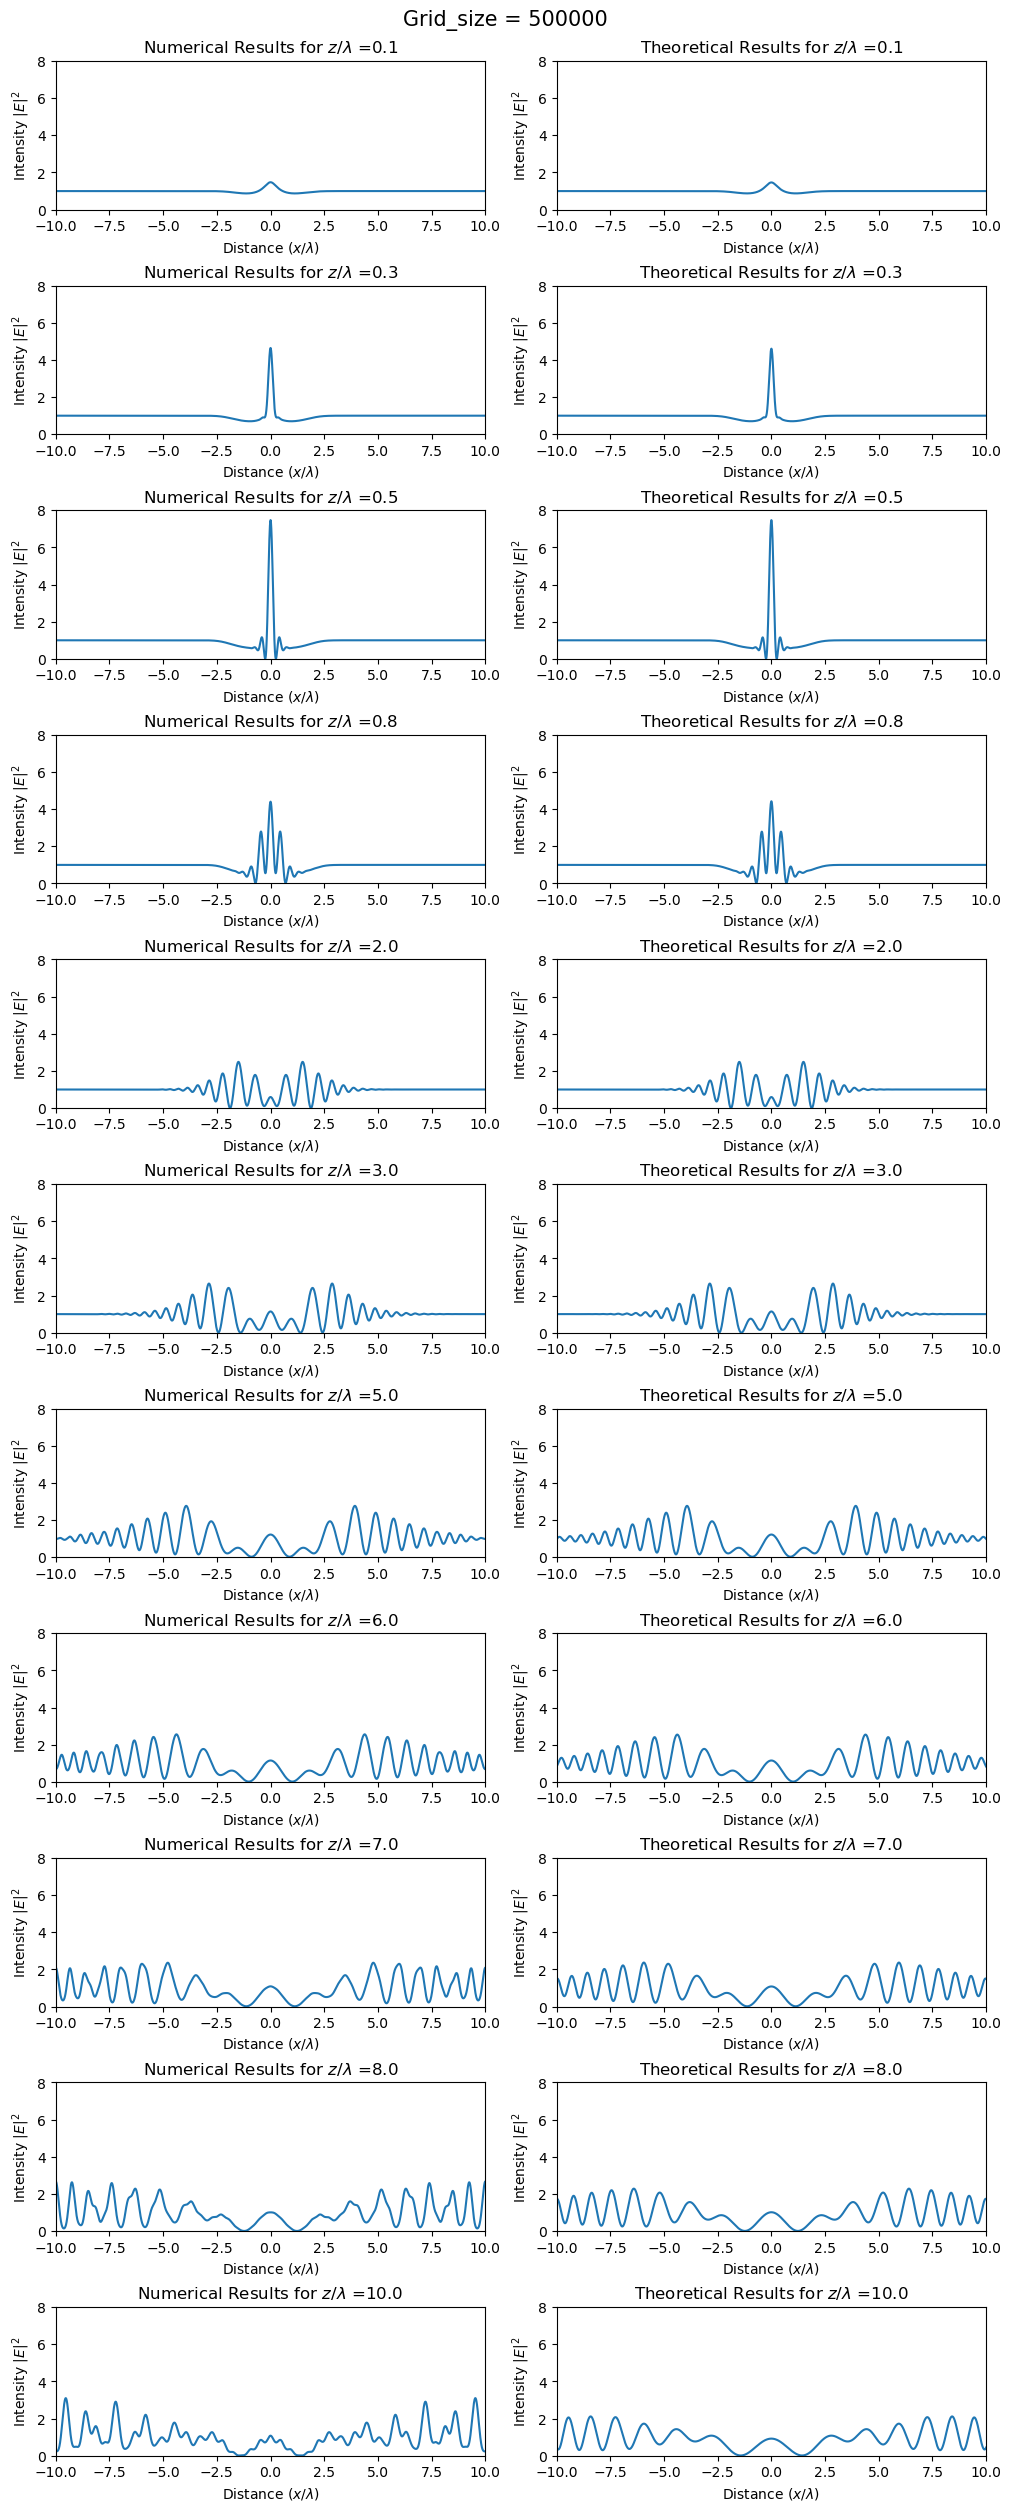

In [27]:
fig, axs = plt.subplots(len(z_values), 2, figsize=(10, 25), constrained_layout=True)

# Добавляем общий заголовок
fig.suptitle(r"Grid_size = " + f"{grid_size}", fontsize=15)

for i, (zi, num_intensity, th_intensity) in enumerate(zip(Z_lambda, numerical_results, I_theory)):
    # Numerical result plot
    axs[i, 0].plot(X, num_intensity)
    axs[i, 0].set_title(r"Numerical Results for $z / \lambda$ ="+f"{zi}")
    axs[i, 0].set_xlabel(r"Distance $(x / \lambda)$")
    axs[i, 0].set_ylabel("Intensity $|E|^2$")
    axs[i, 0].set_xlim([-10, 10])
    axs[i, 0].set_ylim([0, 8])

    # Theoretical result plot
    axs[i, 1].plot(X, th_intensity)
    axs[i, 1].set_title(r"Theoretical Results for $z / \lambda$ ="+ f"{zi}")
    axs[i, 1].set_xlabel(r"Distance $(x / \lambda)$")
    axs[i, 1].set_ylabel("Intensity $|E|^2$")
    axs[i, 1].set_xlim([-10, 10])
    axs[i, 1].set_ylim([0, 8])

# plt.tight_layout()
plt.savefig(f"{grid_size}.png",dpi='figure')
plt.show()

In [ ]:
# r and theta , z is absent
# theta = 10 #radians
# r = np.arange(-3, 3, dr)
# dr = L / grid_size

# def generation_of_phase_screen_step1(r,phi0, z_values,k):
#     #generating of phase screen
#     phi = -phi0*np.exp(-r**2/r0**2)
#     U = np.ones(grid_size, dtype=complex)  # Initial electric field (plane wave)
#     U *= np.exp(1j * phi - 1/(2*k)*(1/))  # Apply the phase screen
#     return U

# def fourier_step2(r,phi, z_values,k):
#     # Step 2: Free-space propagation (Fourier domain multiplication)
#     U_fft = np.fft.fftshift(np.fft.fft(generation_of_phase_screen_step1(r,phi0, z_values, k)))

#     # Create spatial frequency grid
#     K = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(grid_size, d=dr)) # it's like a list of sample rates 
#     #f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even (четн) ,  n = grid_size in my case
#     #f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd (нечетн)
    
    
#     numerical_results = []
#     for zi in z_values:
        
#         H = np.exp(1j * zi * K**2/(2*k) + 1j*K*x)  
#         U_prop_fft = U_fft * H
#         U_prop = np.exp(-1j * k * zi)*np.fft.ifft(np.fft.ifftshift(U_prop_fft))
      
        
#         # Intensity pattern
#         intensity = np.abs(U_prop)**2
#         numerical_results.append(intensity)
    
#     return numerical_results
